Processing img2.ppm...
Num Corners Found: 1429


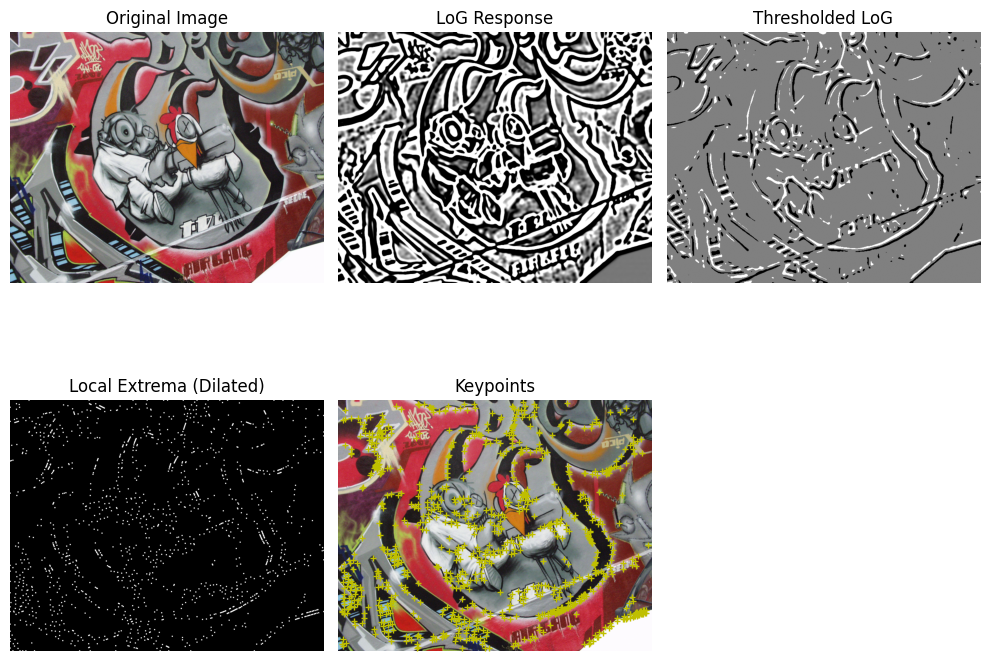

Tutup jendela gambar untuk melanjutkan ke gambar berikutnya (jika ada)...
Processing img1.ppm...
Num Corners Found: 997


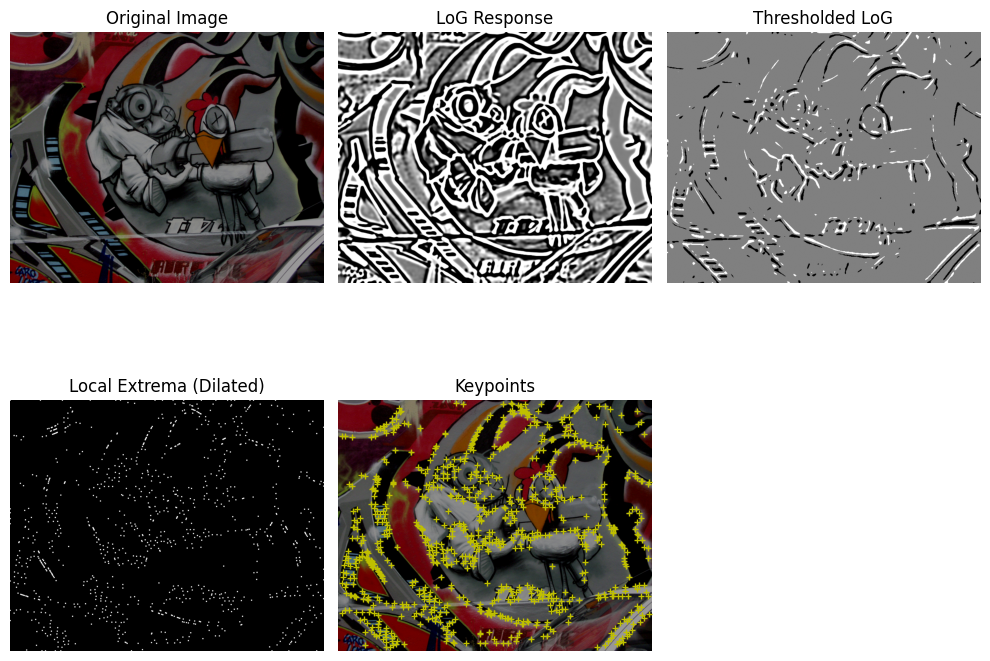

Tutup jendela gambar untuk melanjutkan ke gambar berikutnya (jika ada)...


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace, maximum_filter

def imregionalmax(image, size=3):

    local_max = maximum_filter(image, size=size, mode='constant')
    regional_max = (image == local_max)
    return regional_max

def run_laplacian_keypoint_detector():
    image_files = ['img2.ppm', 'img1.ppm']
    

    sigma = 4.0

    for n_image, filename in enumerate(image_files):
        print(f"Processing {filename}...")
        
        try:
            img = cv2.imread(filename)
            if img is None: raise FileNotFoundError
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float64) / 255.0
        except:
            print(f"File {filename} tidak ditemukan. Membuat gambar dummy.")
            img = np.zeros((400, 400, 3), dtype=np.float64)
            cv2.circle(img, (200, 200), 100, (1, 1, 1), -1)
            cv2.rectangle(img, (50, 50), (150, 150), (0.5, 0.5, 0.5), -1)

        height, width, channels = img.shape
        
        if n_image == 1:
            x = np.arange(1, width + 1)
            y = np.arange(1, height + 1)
            X, Y = np.meshgrid(x, y)
            
            gradient = 0.7 
            
            for n in range(3):
                img[:, :, n] = img[:, :, n] * gradient - 0.1
                
            img = np.clip(img, 0, 1.0)

        img_gray = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

        plt.figure(figsize=(10, 8))
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        img_filt = gaussian_laplace(img_gray, sigma=sigma, mode='reflect')
        
        img_filt = img_filt * (sigma**2)

        plt.subplot(2, 3, 2)
        plt.imshow(img_filt, cmap='gray', vmin=-0.02, vmax=0.02)
        plt.title('LoG Response')
        plt.axis('off')

    
        img_filt_abs = np.abs(img_filt)
        max_val = np.max(img_filt_abs)
        
        threshold = 0.35 * max_val
        img_filt_thresh = img_filt.copy()
        img_filt_thresh[img_filt_abs < threshold] = 0
        
        img_ext_pos = imregionalmax(img_filt_thresh)
        
        img_ext_neg = imregionalmax(-img_filt_thresh)
        
        mask_threshold = (img_filt_abs >= threshold)
        img_ext = (img_ext_pos | img_ext_neg) & mask_threshold

        plt.subplot(2, 3, 3)
        plt.imshow(img_filt_thresh, cmap='gray', vmin=-0.02, vmax=0.02)
        plt.title('Thresholded LoG')
        plt.axis('off')

        kernel_dilate = np.ones((3, 3), np.uint8)
        img_ext_dilated = cv2.dilate(img_ext.astype(np.uint8), kernel_dilate, iterations=1)
        
        plt.subplot(2, 3, 4)
        plt.imshow(img_ext_dilated, cmap='gray')
        plt.title('Local Extrema (Dilated)')
        plt.axis('off')

        rows, cols = np.where(img_ext)
        
        responses = []
        valid_indices = []
        border = int(sigma)
        
        for idx in range(len(rows)):
            r, c = rows[idx], cols[idx]
            if (r > border) and (r < height - border) and \
               (c > border) and (c < width - border):
                resp = img_filt_abs[r, c]
                responses.append(resp)
                valid_indices.append(idx)
                
        responses = np.array(responses)
        valid_rows = rows[valid_indices]
        valid_cols = cols[valid_indices]
        
        print(f"Num Corners Found: {len(responses)}")
        
        sort_idx = np.argsort(responses)[::-1]
        
        plt.subplot(2, 3, 5)
        plt.imshow(img)
        plt.title('Keypoints')
        plt.axis('off')
        
        num_to_plot = min(900, len(responses))
        
        plt.plot(valid_cols[sort_idx[:num_to_plot]], 
                 valid_rows[sort_idx[:num_to_plot]], 
                 'y+', markersize=5, markeredgewidth=1)

        plt.tight_layout()
        plt.show()
        
        print("Tutup jendela gambar untuk melanjutkan ke gambar berikutnya (jika ada)...")

if __name__ == "__main__":
    run_laplacian_keypoint_detector()

Processing 35-a.jpg...
Num Corners: 781


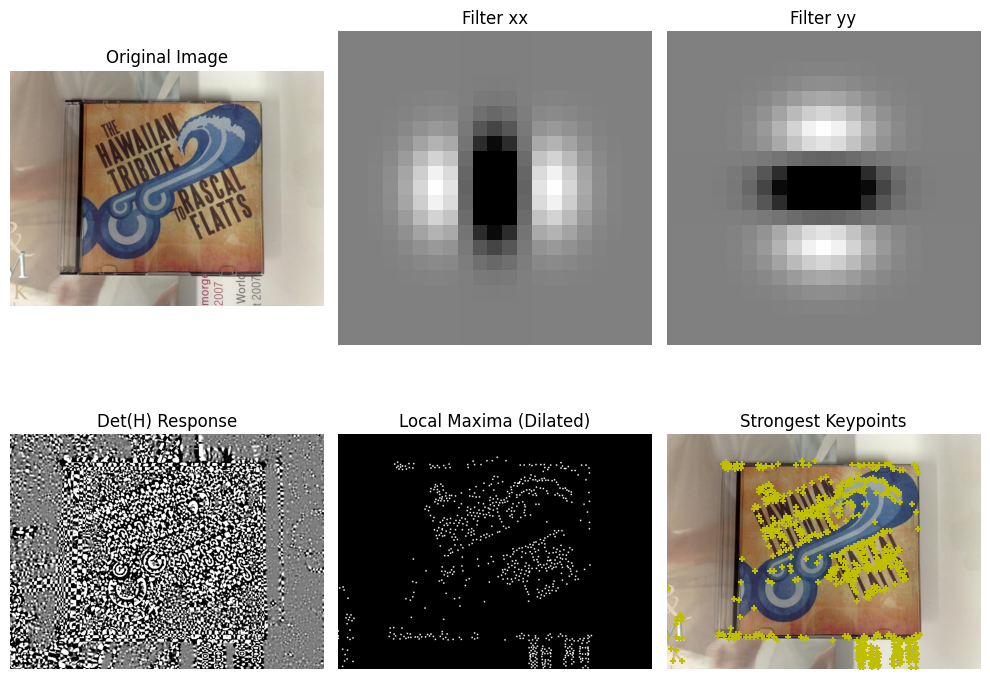

Processing 35-b.jpg...
Num Corners: 1275


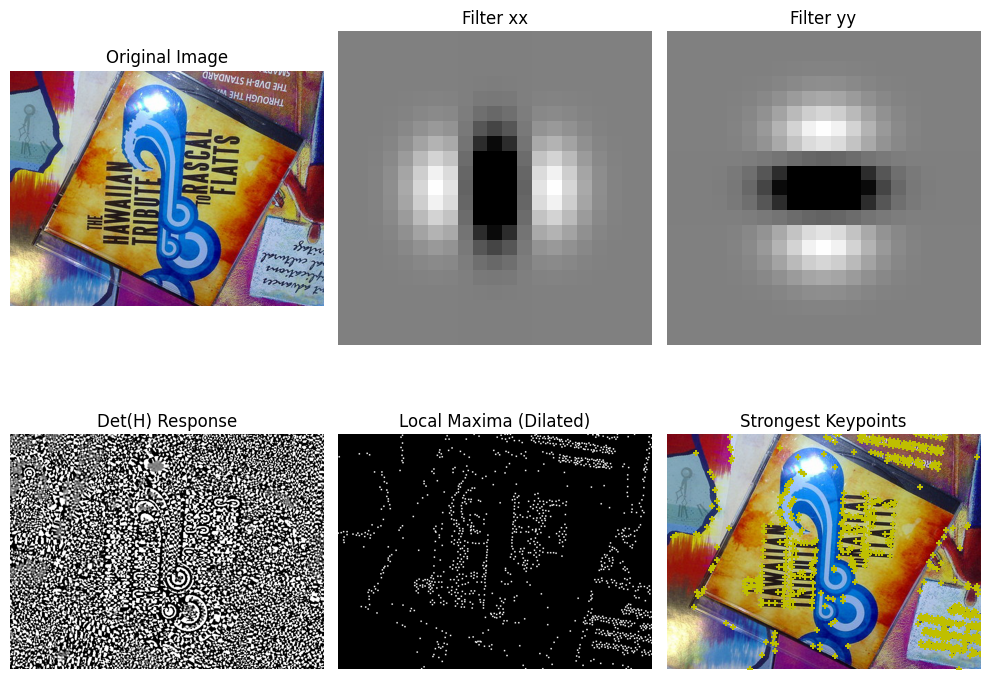

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, maximum_filter

def fspecial_gaussian(size, sigma):
    if size % 2 == 0: size += 1
    k = (size - 1) // 2
    x = np.arange(-k, k + 1)
    y = np.arange(-k, k + 1)
    xx, yy = np.meshgrid(x, y)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def fspecial_sobel(orientation='horizontal'):

    s = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float64)
    return s

def imregionalmax(image, size=3):
    local_max = maximum_filter(image, size=size, mode='constant', cval=0)
    regional_max = (image == local_max)
    regional_max[image == 0] = False
    return regional_max

def run_doh_detector():
    image_files = ['35-a.jpg', '35-b.jpg']
    
    sigma = 2.0
    
    for fname in image_files:
        try:
            temp = cv2.imread(fname)
            if temp is None: raise FileNotFoundError
        except:
            print(f"File {fname} tidak ditemukan. Membuat dummy...")
            dummy = np.zeros((300, 300, 3), dtype=np.uint8)
            cv2.circle(dummy, (100, 100), 10, (255,255,255), -1)
            cv2.circle(dummy, (200, 200), 20, (255,255,255), -1)
            cv2.imwrite(fname, dummy)

    for n_image, filename in enumerate(image_files):
        print(f"Processing {filename}...")
        
        img = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_float = img_rgb.astype(np.float64) / 255.0
        img_gray = np.dot(img_float[...,:3], [0.2989, 0.5870, 0.1140])
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.axis('off')

        g_size = int(10 * sigma + 1)
        g = fspecial_gaussian(g_size, sigma)

        s = fspecial_sobel()
        s_t = s.T
        
        temp_x = convolve(g, s_t, mode='nearest')
        filter_xg = convolve(temp_x, s_t, mode='nearest')
        
        temp_y = convolve(g, s, mode='nearest')
        filter_yg = convolve(temp_y, s, mode='nearest')
        
        temp_xy = convolve(g, s_t, mode='nearest')
        filter_xyg = convolve(temp_xy, s, mode='nearest')
        plt.subplot(2, 3, 2)
        plt.imshow(filter_xg, cmap='gray', vmin=-0.2, vmax=0.2)
        plt.title('Filter xx')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(filter_yg, cmap='gray', vmin=-0.2, vmax=0.2)
        plt.title('Filter yy')
        plt.axis('off')

        img_dxx = convolve(img_gray, filter_xg, mode='nearest')
        img_dyy = convolve(img_gray, filter_yg, mode='nearest')
        img_dxy = convolve(img_gray, filter_xyg, mode='nearest')
        
        img_filt = (img_dxx * img_dyy) - (img_dxy**2)
        
        plt.subplot(2, 3, 4)
        plt.imshow(img_filt, cmap='gray', vmin=-0.001, vmax=0.001)
        plt.title('Det(H) Response')
        plt.axis('off')

        max_val = np.max(img_filt)
        threshold = 0.05 * max_val
        
        img_filt_thresh = img_filt.copy()
        img_filt_thresh[img_filt < threshold] = 0
        
        img_ext = imregionalmax(img_filt_thresh)
        
        num_corners = np.sum(img_ext)
        print(f"Num Corners: {num_corners}")

        kernel_dilate = np.ones((3,3), np.uint8)
        img_ext_dilated = cv2.dilate(img_ext.astype(np.uint8), kernel_dilate, iterations=1)
        
        plt.subplot(2, 3, 5)
        plt.imshow(img_ext_dilated, cmap='gray')
        plt.title('Local Maxima (Dilated)')
        plt.axis('off')

        rows, cols = np.where(img_ext)
        responses = img_filt[rows, cols]
        
        sort_idx = np.argsort(responses)[::-1]
        
        plt.subplot(2, 3, 6)
        plt.imshow(img_rgb)
        plt.title('Strongest Keypoints')
        plt.axis('off')
        
        limit = min(600, len(sort_idx))
        for i in range(limit):
            idx = sort_idx[i]
            r, c = rows[idx], cols[idx]
            plt.plot(c, r, 'y+', markersize=5, markeredgewidth=1.5)

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    run_doh_detector()

Processing ukbench00732.jpg...


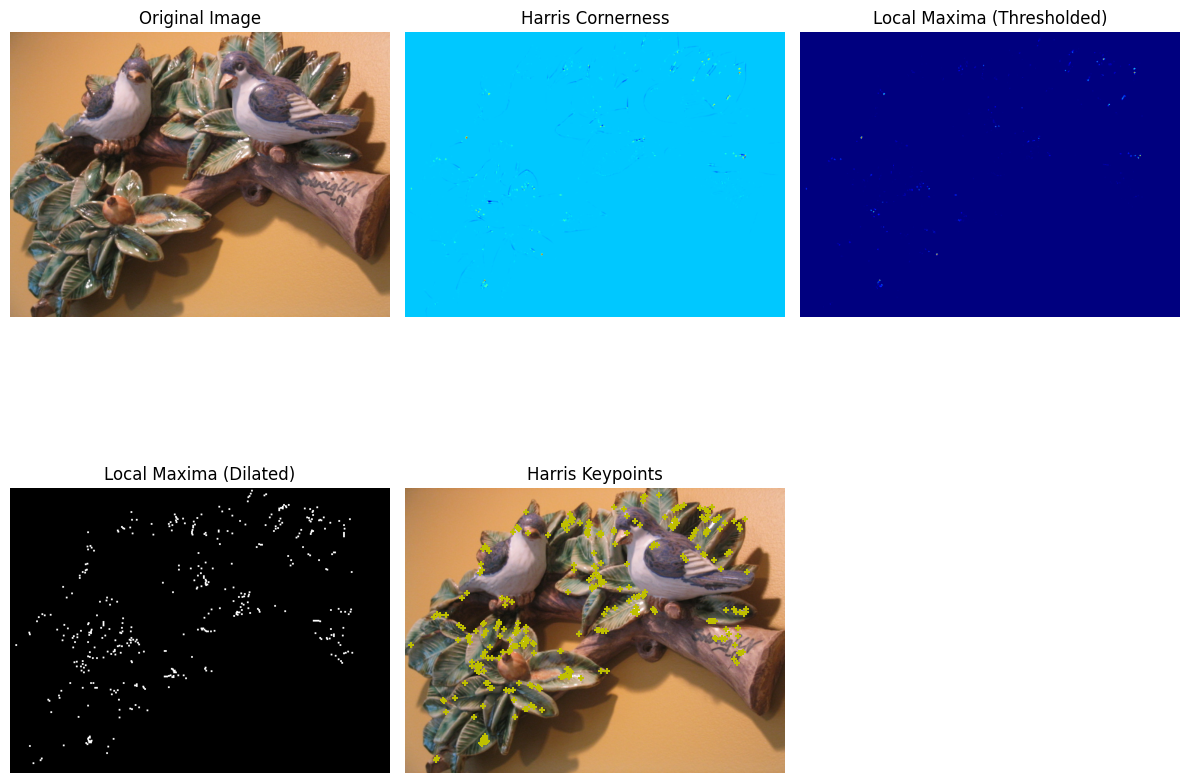

Total corners found: 424
Tutup jendela gambar untuk lanjut ke gambar berikutnya...
Processing ukbench00733.jpg...


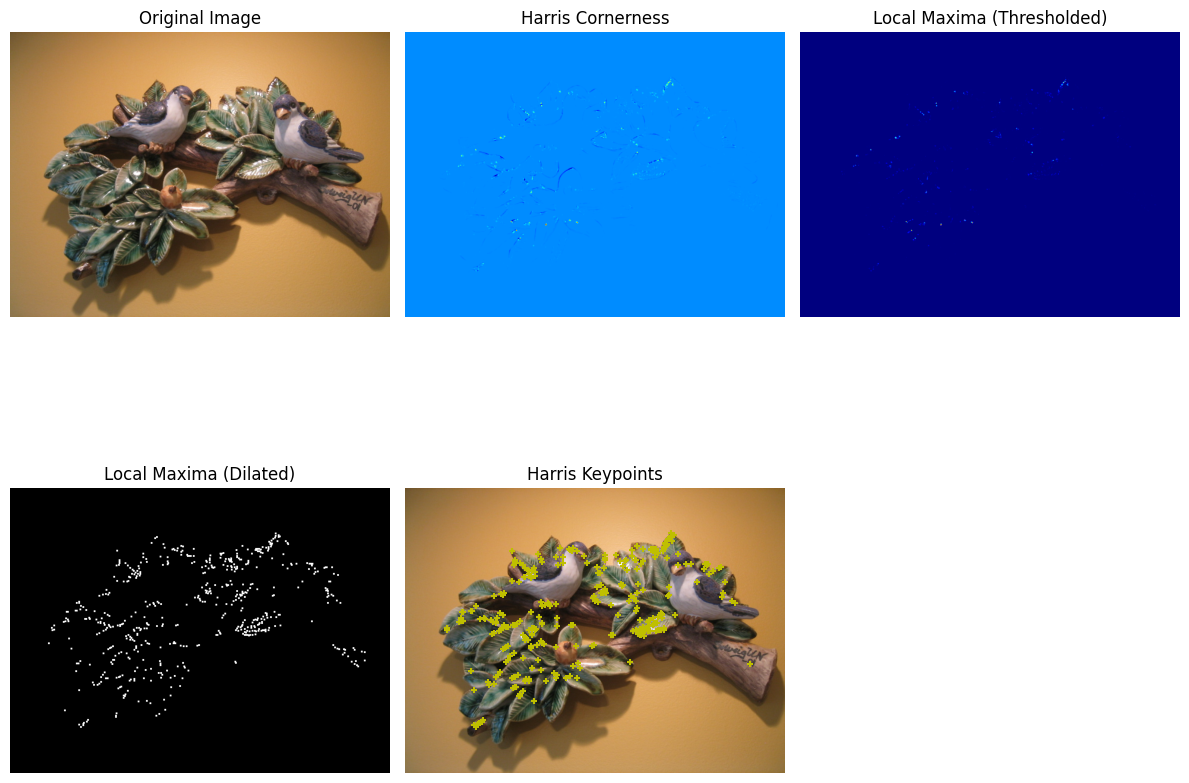

Total corners found: 551
Tutup jendela gambar untuk lanjut ke gambar berikutnya...


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

def imregionalmax(image, size=3):

    local_max = maximum_filter(image, size=size, mode='constant', cval=0)
    regional_max = (image == local_max)
    regional_max[image == 0] = False
    return regional_max

def run_harris_detector():
    image_files = ['ukbench00732.jpg', 'ukbench00733.jpg']
    
    for fname in image_files:
        try:
            temp = cv2.imread(fname)
            if temp is None: raise FileNotFoundError
        except:
            print(f"File '{fname}' tidak ditemukan. Membuat gambar dummy...")
            dummy = np.zeros((400, 400, 3), dtype=np.uint8)
            cv2.rectangle(dummy, (50, 50), (150, 150), (255, 255, 255), -1)
            cv2.rectangle(dummy, (200, 100), (300, 300), (200, 200, 200), -1)
            center = (200, 200)
            M = cv2.getRotationMatrix2D(center, 15, 1.0)
            dummy = cv2.warpAffine(dummy, M, (400, 400))
            cv2.imwrite(fname, dummy)

    for n_image, filename in enumerate(image_files):
        print(f"Processing {filename}...")
        
        img_bgr = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        img_float = img_rgb.astype(np.float64) / 255.0
        
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0

        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.axis('off')

        C = cv2.cornerHarris(img_gray.astype(np.float32), blockSize=2, ksize=3, k=0.04)
        
        plt.subplot(2, 3, 2)
        plt.imshow(C, cmap='jet')
        plt.title('Harris Cornerness')
        plt.axis('off')

        max_val = np.max(C)
        threshold = 0.01 * max_val
        
        C_thresh = C.copy()
        C_thresh[C < threshold] = 0
        
        img_ext = imregionalmax(C_thresh)
        
        plt.subplot(2, 3, 3)
        plt.imshow(C_thresh, cmap='jet')
        plt.title('Local Maxima (Thresholded)')
        plt.axis('off')

        kernel_dilate = np.ones((3, 3), np.uint8)
        img_ext_dilated = cv2.dilate(img_ext.astype(np.uint8), kernel_dilate, iterations=1)
        
        plt.subplot(2, 3, 4)
        plt.imshow(img_ext_dilated, cmap='gray')
        plt.title('Local Maxima (Dilated)')
        plt.axis('off')

        rows, cols = np.where(img_ext)
        
        responses = C[rows, cols]
        
        sort_idx = np.argsort(responses)[::-1]
        
        num_corners = len(rows)
        limit = min(300, num_corners)
        
        top_rows = rows[sort_idx[:limit]]
        top_cols = cols[sort_idx[:limit]]
        
        plt.subplot(2, 3, 5)
        plt.imshow(img_rgb)
        plt.title('Harris Keypoints')
        plt.axis('off')
        
        plt.plot(top_cols, top_rows, 'y+', markersize=5, markeredgewidth=1.5)

        

        plt.tight_layout()
        plt.show()
        
        print(f"Total corners found: {num_corners}")
        print("Tutup jendela gambar untuk lanjut ke gambar berikutnya...")

if __name__ == "__main__":
    run_harris_detector()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


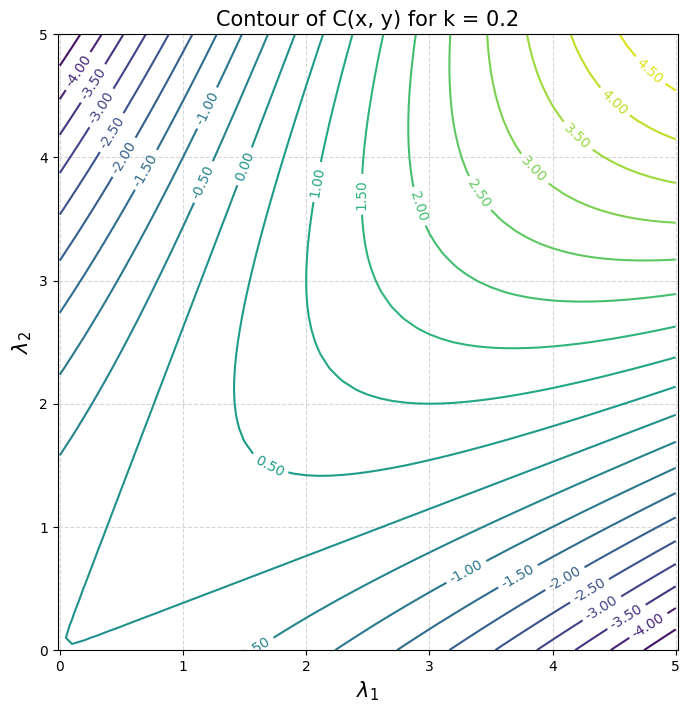

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lambda1 = np.arange(0, 5.1, 0.1)
lambda2 = np.arange(0, 5.1, 0.1)

L1, L2 = np.meshgrid(lambda1, lambda2)

k = 0.2

C = (L1 * L2) - k * (L1 + L2)**2

plt.figure(figsize=(8, 8))


contour_set = plt.contour(L1, L2, C, levels=20, cmap='viridis')

plt.clabel(contour_set, inline=True, fontsize=10, fmt='%.2f')

plt.xlabel(r'$\lambda_1$', fontsize=15)
plt.ylabel(r'$\lambda_2$', fontsize=15)
plt.title(f'Contour of C(x, y) for k = {k}', fontsize=15)

plt.axis('equal')
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Processing 019_Reference.jpg...


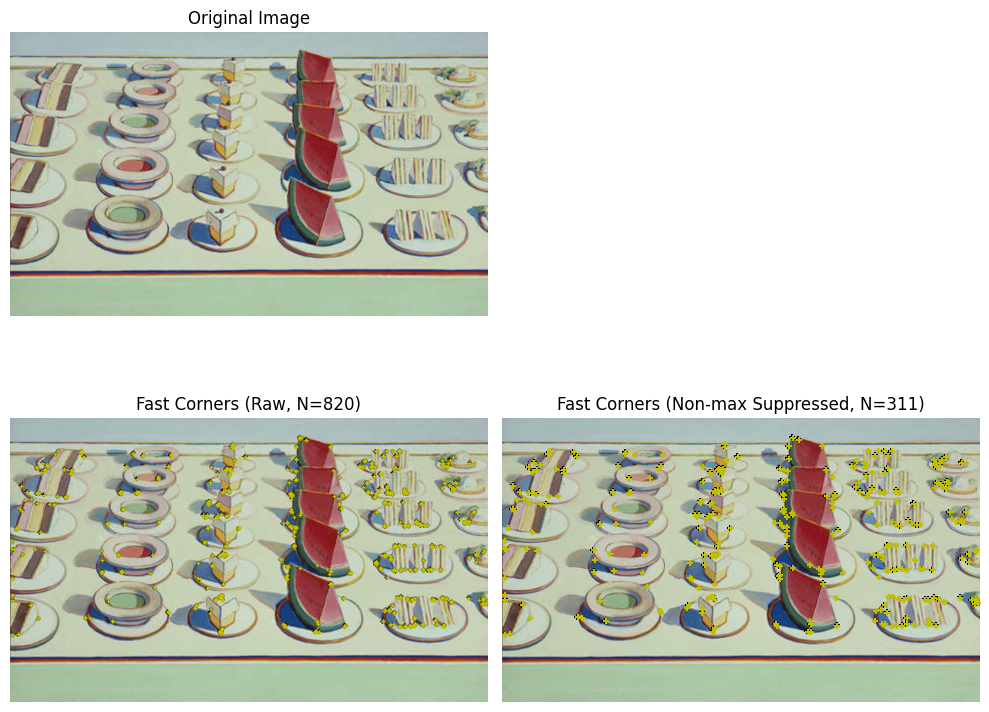

Processing 019_Palm.jpg...


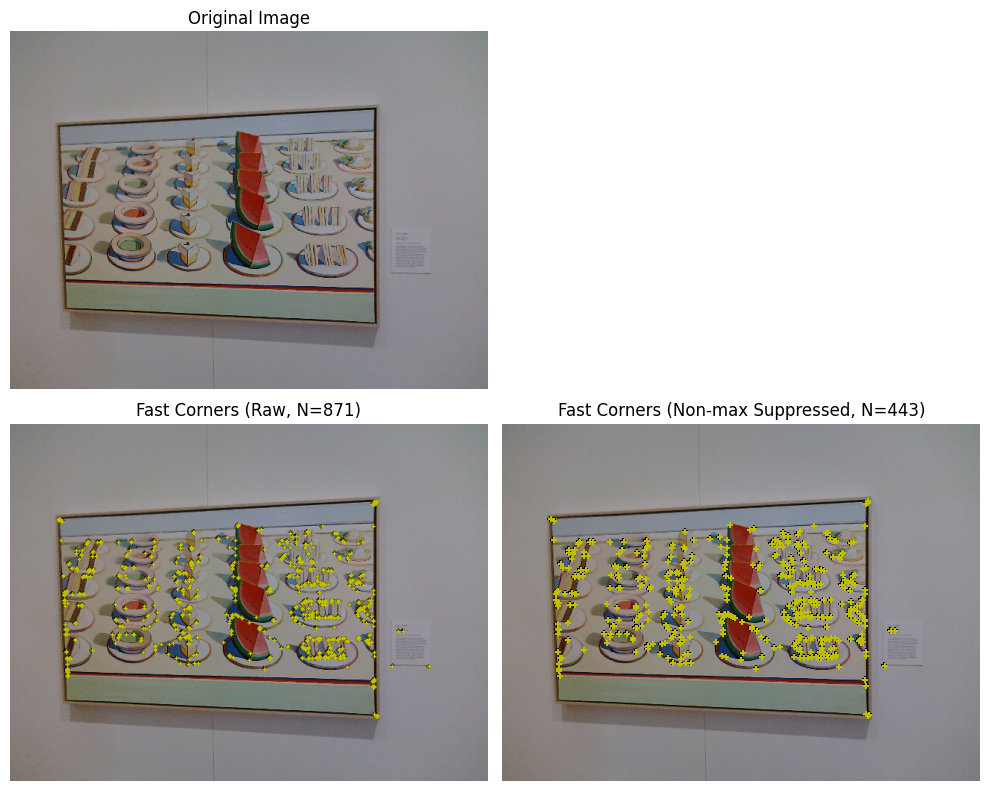

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def run_fast_detector():
    image_files = ['019_Reference.jpg', '019_Palm.jpg']
    
    for fname in image_files:
        if not os.path.exists(fname):
            print(f"File {fname} tidak ditemukan. Membuat dummy...")
            dummy = np.zeros((600, 800, 3), dtype=np.uint8)
            for y in range(0, 600, 50):
                for x in range(0, 800, 50):
                    if (x+y) % 100 == 0:
                        cv2.rectangle(dummy, (x, y), (x+40, y+40), (200, 200, 200), -1)
            cv2.imwrite(fname, dummy)

    target_height = 480
    threshold = 50

    for filename in image_files:
        print(f"Processing {filename}...")

        img = cv2.imread(filename)
        h, w = img.shape[:2]
        
        target_width = int(round(w * target_height / h))
        img = cv2.resize(img, (target_width, target_height))
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        plt.figure(figsize=(10, 8))
        

        plt.subplot(2, 2, 1)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.axis('off')

        fast_raw = cv2.FastFeatureDetector_create(threshold=threshold, 
                                                  nonmaxSuppression=False, 
                                                  type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
        kp_raw = fast_raw.detect(img_gray, None)
        
        plt.subplot(2, 2, 3)
        plt.imshow(img_rgb)
        plt.title(f'Fast Corners (Raw, N={len(kp_raw)})')
        plt.axis('off')
        
        if kp_raw:
            pts_raw = cv2.KeyPoint_convert(kp_raw)
            plt.plot(pts_raw[:, 0], pts_raw[:, 1], 'k+', markersize=3, markeredgewidth=1)
            plt.plot(pts_raw[:, 0]+0.5, pts_raw[:, 1]+0.5, 'y+', markersize=3, markeredgewidth=1)

        fast_nms = cv2.FastFeatureDetector_create(threshold=threshold, nonmaxSuppression=True, type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
        kp_nms = fast_nms.detect(img_gray, None)
        
        plt.subplot(2, 2, 4)
        plt.imshow(img_rgb)
        plt.title(f'Fast Corners (Non-max Suppressed, N={len(kp_nms)})')
        plt.axis('off')
        
        if kp_nms:
            pts_nms = cv2.KeyPoint_convert(kp_nms)
            plt.plot(pts_nms[:, 0], pts_nms[:, 1], 'k+', markersize=5, markeredgewidth=1.5)
            plt.plot(pts_nms[:, 0]+0.5, pts_nms[:, 1]+0.5, 'y+', markersize=5, markeredgewidth=1.5)

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    run_fast_detector()